## 1. Load packages

In [ ]:
!pip install tweet-preprocessor
!pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9674 sha256=40df9e62089a6f49a86f4d0925386b2bbea62fd48fa5f1479dc69b00e1c51679
  Stored in directory: /root/.cache/pip/wheels/bd/a8/c3/3cf2c14a1837a4e04bd98631724e81f33f462d86a1d895fae0
Successfully built wget


In [ ]:
import logging
import wget
import os
import matplotlib.pyplot as plt
import re
import numpy as np
import pandas as pd
import preprocessor as p
import seaborn as sns
%matplotlib inline

## 2. Download dataset

In [ ]:
print('Downloading dataset...')

# The URL for the dataset zip file
url = 'http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip'

# Download the file 
wget.download(url)

# Unzip the dataset
!unzip trainingandtestdata.zip

Archive:  trainingandtestdata.zip
  inflating: testdata.manual.2009.06.14.csv  
  inflating: training.1600000.processed.noemoticon.csv  


# 3. EDA

In [ ]:
# load the data into dataframe
df = pd.read_csv("./training.1600000.processed.noemoticon.csv", 
     names=['label', 'twitter_id', 'time', 'query', 'account', 'tweet'],
     encoding='latin-1')

# print the number of tweets
print('Number of tweets: {:,}\n'.format(df.shape[0]))

# sample 10 records from the data
df.sample(10)

Number of tweets: 1,600,000



,label,twitter_id,time,query,account,tweet
541200,0,2200003196,Tue Jun 16 18:18:12 PDT 2009,NO_QUERY,LaLaLindsey0609,@chrishasboobs AHHH I HOPE YOUR OK!!!
750,0,1467998485,Mon Apr 06 23:11:14 PDT 2009,NO_QUERY,sexygrneyes,"@misstoriblack cool , i have no tweet apps fo..."
766711,0,2300048954,Tue Jun 23 13:40:11 PDT 2009,NO_QUERY,sammydearr,@TiannaChaos i know just family drama. its la...
285055,0,1993474027,Mon Jun 01 10:26:07 PDT 2009,NO_QUERY,Lamb_Leanne,School email won't open and I have geography ...
705995,0,2256550904,Sat Jun 20 12:56:51 PDT 2009,NO_QUERY,yogicerdito,upper airways problem
379611,0,2052380495,Sat Jun 06 00:32:16 PDT 2009,NO_QUERY,Yengching,Going to miss Pastor's sermon on Faith...
1189018,4,1983449090,Sun May 31 13:10:36 PDT 2009,NO_QUERY,jessig06,on lunch....dj should come eat with me
667030,0,2245479748,Fri Jun 19 16:11:29 PDT 2009,NO_QUERY,felicityfuller,@piginthepoke oh why are you feeling like that?
93541,0,1770705699,Mon May 11 22:01:32 PDT 2009,NO_QUERY,stephiiheyy,gahh noo!peyton needs to live!this is horrible
1097326,4,1970386589,Sat May 30 03:39:34 PDT 2009,NO_QUERY,wyndwitch,@mrstessyman thank you glad you like it! There...


In [ ]:
# number of unique id
print(df['twitter_id'].nunique())

# number of unique account
print(df['account'].nunique())

1598315
659775


In [ ]:
# split the date column into week, month, day, time, timezone, year
df[['week','month','day','time','timezone','year']] = df['time'].str.split(" ", expand=True)

# check if time is normalized (if the timezone is the same)
df['timezone'].nunique()

1

In [ ]:
df

,label,twitter_id,time,query,account,tweet,week,month,day,timezone,year
0,0,1467810369,22:19:45,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",Mon,Apr,06,PDT,2009
1,0,1467810672,22:19:49,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,Mon,Apr,06,PDT,2009
2,0,1467810917,22:19:53,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,Mon,Apr,06,PDT,2009
3,0,1467811184,22:19:57,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,Mon,Apr,06,PDT,2009
4,0,1467811193,22:19:57,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",Mon,Apr,06,PDT,2009
...,...,...,...,...,...,...,...,...,...,...,...
1599995,4,2193601966,08:40:49,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...,Tue,Jun,16,PDT,2009
1599996,4,2193601969,08:40:49,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...,Tue,Jun,16,PDT,2009
1599997,4,2193601991,08:40:49,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...,Tue,Jun,16,PDT,2009
1599998,4,2193602064,08:40:49,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...,Tue,Jun,16,PDT,2009


# 4. Extract mentions

In [ ]:
# write a regex to match the pattern for mention
mentions_re = r'(?<=@)\w+'
# print the first tweet
print(df["tweet"].iloc[0])
"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

# print the mention in the first tweet 
print(re.findall(mentions_re, df["tweet"].iloc[0]))

@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
['switchfoot']


In [ ]:
# write a function to extract all of the mentions from each tweet
def extract_mentions(full_texts):
   mentions = pd.DataFrame(full_texts.str.lower().str.findall(mentions_re).explode().dropna())
   mentions.columns = ["mentions"]
   mentions = mentions.merge(df['label'], left_index=True, right_index=True, how='left')
   return mentions

# apply the function to the tweet column
mentions = extract_mentions(df['tweet'])
mentions['mentions'].value_counts()[:5]

mileycyrus       4580
tommcfly         3904
ddlovato         3474
jonasbrothers    2384
davidarchie      1386
Name: mentions, dtype: int64

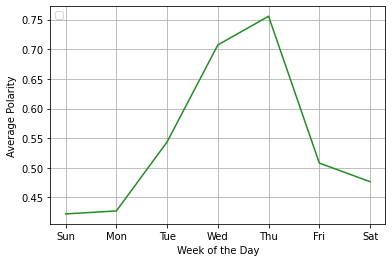

In [ ]:
# pivot the table
by_week = pd.pivot_table(df, values='year', index=['label'], columns=['week'], aggfunc='count')
cols = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
by_week[cols] = by_week[cols] / by_week[cols].sum()
by_week = by_week.transpose().reindex(cols)
by_week.index.name = None
by_week.columns.name = None

# plot the proportion of tweets with negative polarity across the whole week
sns.lineplot(data=by_week, x=by_week.index, y=0, color='forestgreen')
plt.title('')
plt.legend(loc=2)
plt.xlabel("Week of the Day")
plt.ylabel("Average Polarity")
plt.grid()
plt.show()

In [ ]:
df.to_csv('tweet_sent.csv')

# Sentiment Analysis with BERT

In [1]:
!nvidia-smi

Sun Mar  5 05:00:41 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P0    26W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install -q -U watermark

In [3]:
!pip install -qq transformers

In [4]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

Python implementation: CPython
Python version       : 3.8.10
IPython version      : 7.9.0

numpy       : 1.22.4
pandas      : 1.3.5
torch       : 1.13.1+cu116
transformers: 4.26.1



In [5]:
#@title Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap


%matplotlib inline
%config InlineBackend.figure_format='retina'

# sns.set(style='whitegrid', palette='muted', font_scale=1.2)

# HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

# sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

# rcParams['figure.figsize'] = 12, 8

# RANDOM_SEED = 42
# np.random.seed(RANDOM_SEED)
# torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Train-test split

In [6]:
# Build a BERT based tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [7]:
df_model = pd.concat([df.loc[df['label'] == 0].sample(frac=0.01), df.loc[df['label'] == 4].sample(frac=0.01)])
# df_model.to_csv('tweet_sent_model.csv')
# df_model = pd.read_csv('tweet_sent_model.csv')
df_model.loc[df_model["label"] == 4, "label"] = 1

In [8]:
# store length of each tweet
token_lens = []

# iterate through the tweet column
for txt in df_model.tweet:
   tokens = tokenizer.encode(txt)
   token_lens.append(len(tokens))

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


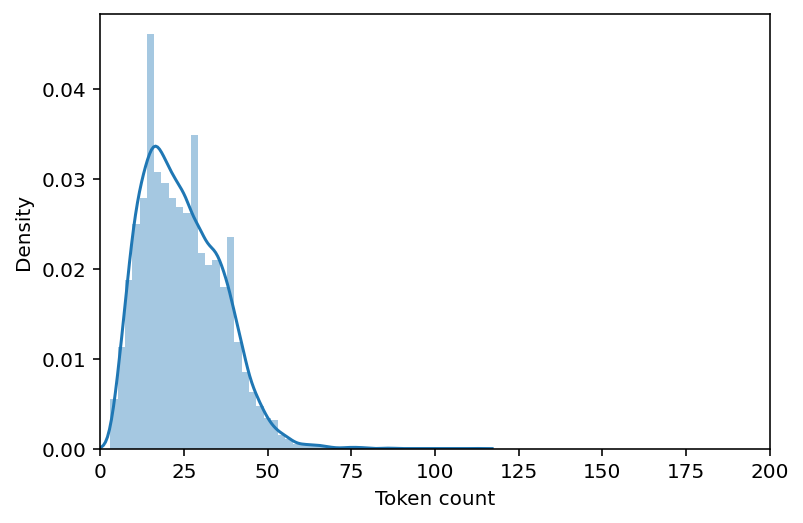

In [9]:
# plot the distribution of tweet lengths 
sns.distplot(token_lens)
plt.xlim([0, 200])
plt.xlabel('Token count');

In [10]:
df_train, df_test = train_test_split(df_model, test_size=0.1, random_state=42)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=42)

## Build the classifier

In [12]:
# create a tokenizer
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [13]:
# create a data loader
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.tweet.to_numpy(),
    targets=df.label.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [14]:
MAX_LEN = 125
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [15]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [16]:
# load BERT
bert_model = BertModel.from_pretrained('bert-base-cased', return_dict=False)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [17]:
# create the classifier
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained('bert-base-cased', return_dict=False)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [18]:
# instantiate the model and move to classifier
model = SentimentClassifier(2)
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [19]:
# check the dimention of input
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

In [20]:
# check the hidden layer size
print(bert_model.config.hidden_size)

768


In [21]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.2304, 0.7696],
        [0.2834, 0.7166],
        [0.1730, 0.8270],
        [0.1251, 0.8749],
        [0.1942, 0.8058],
        [0.2242, 0.7758],
        [0.3353, 0.6647],
        [0.5796, 0.4204],
        [0.3072, 0.6928],
        [0.3653, 0.6347],
        [0.3781, 0.6219],
        [0.3877, 0.6123],
        [0.1363, 0.8637],
        [0.3642, 0.6358],
        [0.4479, 0.5521],
        [0.2950, 0.7050]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

## Training

In [22]:
EPOCHS = 8

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [23]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [24]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [25]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/8
----------
Train loss 0.4857352459265126 accuracy 0.7685416666666667
Val   loss 0.4103033171594143 accuracy 0.81875

Epoch 2/8
----------
Train loss 0.2707135284360912 accuracy 0.8961111111111111
Val   loss 0.581130108833313 accuracy 0.81125

Epoch 3/8
----------
Train loss 0.1603570611783976 accuracy 0.9538888888888889
Val   loss 0.7748090094700456 accuracy 0.81375

Epoch 4/8
----------
Train loss 0.09925389545109485 accuracy 0.9754166666666667
Val   loss 1.0215172763576266 accuracy 0.81375

Epoch 5/8
----------
Train loss 0.059240124417346024 accuracy 0.9866666666666667
Val   loss 1.0887920645647682 accuracy 0.81

Epoch 6/8
----------
Train loss 0.050139884708898734 accuracy 0.9894444444444445
Val   loss 1.232879184919875 accuracy 0.8125

Epoch 7/8
----------
Train loss 0.03146361627515742 accuracy 0.9932638888888888
Val   loss 1.3020428043184802 accuracy 0.81375

Epoch 8/8
----------
Train loss 0.018890714899413675 accuracy 0.9955555555555555
Val   loss 1.392997169571172 a

## Accuracy

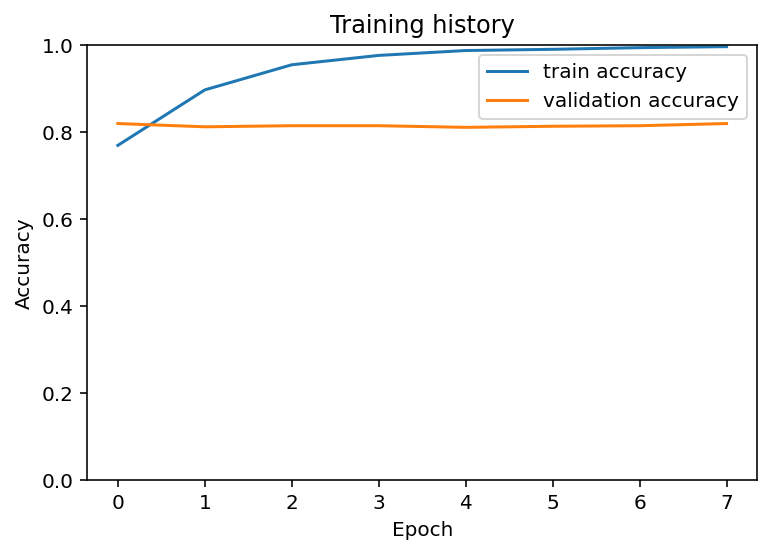

In [26]:
plt.plot([i.cpu().numpy() for i in history['train_acc']], label='train accuracy')
plt.plot([i.cpu().numpy() for i in history['val_acc']], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);